In [1]:
!pip install transformers[torch] tokenizers datasets evaluate rouge_score sentencepiece huggingface_hub --upgrade

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.2/417.2 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 98.1 MB/s eta 0:00:00:00:0100:01
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b95c48740cd899643c4d4510c27ee0f6dc969e0e9ffbfa9537a809046c77c565
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.4
    Uninstalling huggingface-hub-0.23.4:
      Successfully uninstalled huggingface-hub-0.23.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.3
    Uninstalling transformers-4.42.3:
      Successfu

In [2]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from datasets import load_dataset
import evaluate
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, GenerationConfig
import torch
from nltk.corpus import stopwords
from nltk.translate.bleu_score import corpus_bleu
from sklearn.metrics import f1_score

2024-07-27 11:30:21.043915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 11:30:21.044026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 11:30:21.166379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")

Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [4]:
print(f"Dataset structure: {dataset}")

# Analyzing the structure of the dataset
print("Dataset columns and sample data:")
print(dataset["train"].column_names)
print(dataset["train"].features)

# Display dataset structure
df = pd.DataFrame(dataset['train'])

# Analyze the structure and content of the dataset
print("Dataset structure:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nDataset description:")
print(df.describe())


# Check for missing values
print("\nMissing Values in Data:")
print(df.isnull().sum())


Dataset structure: DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 56402
    })
})
Dataset columns and sample data:
['question', 'answer']
{'question': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None)}
Dataset structure:
                                            question  \
0  Why whenever I get in the shower my girlfriend...   
1            What is a proxy, and how can I use one?   
2  What song has the lyrics "someone left the cak...   
3  I am the owner of an adult website called http...   
4  Does the Bible mention anything about a place ...   

                                              answer  
0  Isn’t it awful? You would swear that there was...  
1  A proxy server is a system or router that prov...  
2                                 MacArthur's Park\n  
3  Don't let apps that are liers put adds on your...  
4  St. John in the book of Revelation mentions an...  

Dataset info:
<class 'pandas.core.frame.

In [5]:
contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I had / I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they shall / they will",
    "they'll've": "they shall have / they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what'll've": "what shall have / what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who shall / who will",
    "who'll've": "who shall have / who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

In [6]:
import re

def expand_contractions(text, contractions_dict):
    if not text:
        return ""
    for contraction, expansion in contractions_dict.items():
        text = re.sub(r'\b{}\b'.format(re.escape(contraction)), expansion, text)
    return text

# Text preprocessing function
def text_preprocessing(text):
    if pd.isnull(text):  # Check if the text is NaN
        return ''
    
    # Expand contractions first
    text = expand_contractions(text, contractions_dict)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Replace non-alphabetic characters with spaces, but keep contractions intact
    text = re.sub(r'[^a-z\' ]', ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Function to preprocess texts
def preprocess_texts(df):
    df['question'] = df['question'].apply(lambda x: text_preprocessing(x))
    df['answer'] = df['answer'].apply(lambda x: text_preprocessing(x))
    return df

df_train = preprocess_texts(df)

In [7]:
print(df)

                                                question  \
0      why whenever i get in the shower my girlfriend...   
1                  what is a proxy and how can i use one   
2      what song has the lyrics someone left the cake...   
3      i am the owner of an adult website called http...   
4      does the bible mention anything about a place ...   
...                                                  ...   
56397  alexandria ocasio cortez said going by track r...   
56398          is becoming a doctor financially worth it   
56399   where can one find the best biryani in bangalore   
56400   which smartphone is best for middle class people   
56401  why am i always rejected by the men i am inter...   

                                                  answer  
0      isn t it awful you would swear that there wasn...  
1      a proxy server is a system or router that prov...  
2                                       macarthur's park  
3      don't let apps that are liers put ad

In [8]:
sample_text = df_train['answer'].iloc[4]
orig = df['answer'].iloc[4]
expanded_text = expand_contractions(sample_text, contractions_dict)
print(f"Original: {orig}")
print(f"Expanded: {expanded_text}")


Original: st john in the book of revelation mentions an address that some scholars suggest might refer the the place that has become known as purgatory somewhere close to pennsylvania av
Expanded: st john in the book of revelation mentions an address that some scholars suggest might refer the the place that has become known as purgatory somewhere close to pennsylvania av


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


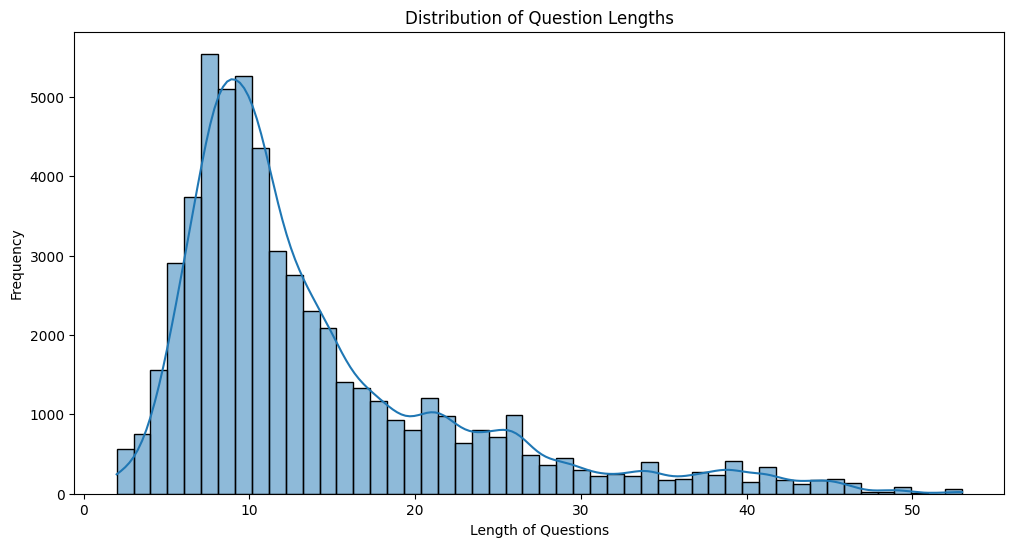

In [9]:
# Data Visualization
# Distribution of question lengths
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(df_train['question_length'], bins=50, kde=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Length of Questions')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


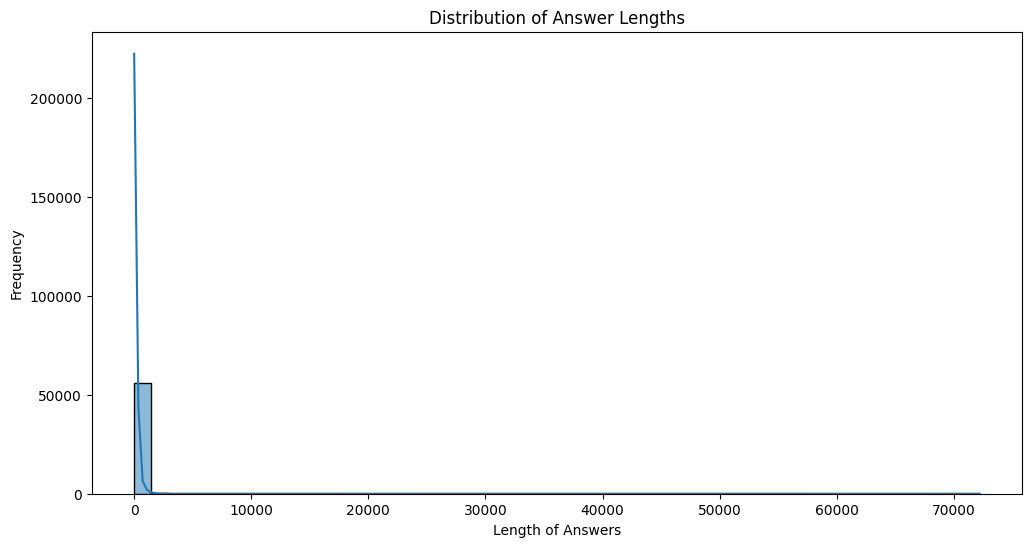

In [10]:
# Distribution of answer lengths
df_train['answer_length'] = df_train['answer'].apply(lambda x: len(x.split()))

# Handle possible infinite values
df_train = df_train.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(12, 6))
sns.histplot(df_train['answer_length'], bins=50, kde=True)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Length of Answers')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


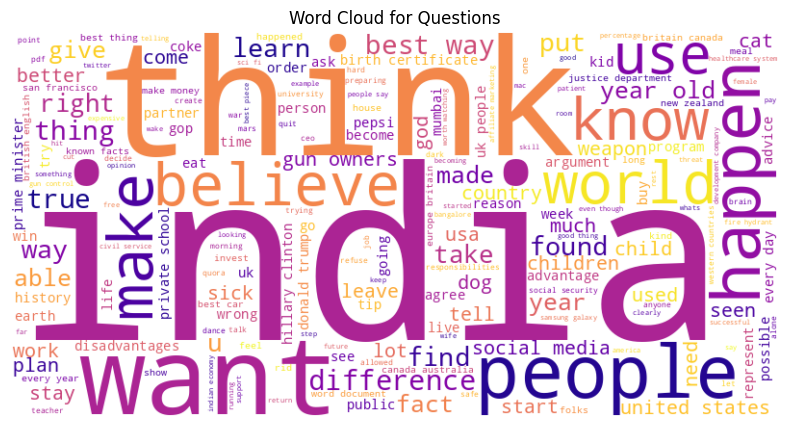

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
import matplotlib.cm as cm

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Load stop words from nltk and wordcloud
nltk_stopwords = set(stopwords.words('english'))
wordcloud_stopwords = set(STOPWORDS)

# Combine NLTK and WordCloud stop words
stop_words = nltk_stopwords.union(wordcloud_stopwords)

# Word cloud for questions
text = ' '.join(df_train['question'])

wordcloud = WordCloud(stopwords=stop_words,width=800, height=400, background_color='white', colormap="plasma").generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Questions')
plt.show()

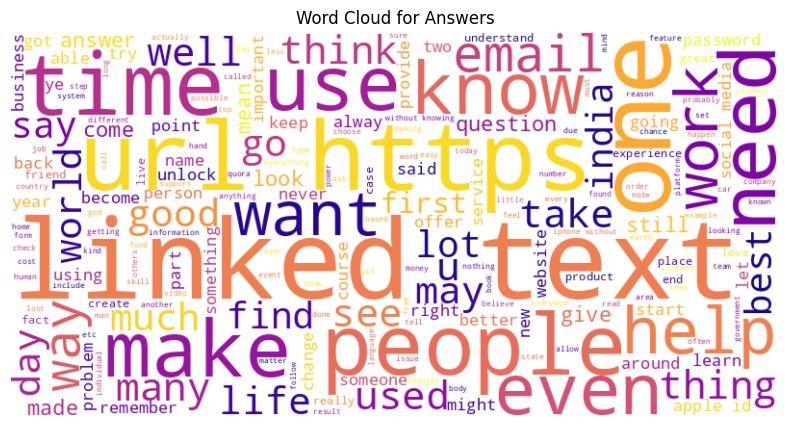

In [12]:
import matplotlib.cm as cm

# Generate the word cloud
text = ' '.join(df_train['answer'])
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap="plasma", stopwords=stop_words).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Answers')
plt.show()

In [13]:
print(type(df_train))
print(type(dataset))

<class 'pandas.core.frame.DataFrame'>
<class 'datasets.dataset_dict.DatasetDict'>


In [14]:
from datasets import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration
df_train = df_train[['question','answer']]
dataset = Dataset.from_pandas(df_train)
dataset = dataset.train_test_split(test_size=0.25)
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [15]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 42301
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 14101
    })
})


In [16]:
prefix = "answer the question: "

# Define preprocessing function for model
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["question"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    labels = tokenizer(text_target=examples["answer"], max_length=512, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/42301 [00:00<?, ? examples/s]

Map:   0%|          | 0/14101 [00:00<?, ? examples/s]

In [17]:
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import f1_score

# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Decode predictions and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Calculate ROUGE scores
    rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    for pred, label in zip(decoded_preds, decoded_labels):
        scores = rouge_scorer.score(label, pred)
        rouge_scores['rouge1'] += scores['rouge1'].fmeasure
        rouge_scores['rouge2'] += scores['rouge2'].fmeasure
        rouge_scores['rougeL'] += scores['rougeL'].fmeasure
    
    num_samples = len(decoded_preds)
    rouge_scores = {key: score / num_samples for key, score in rouge_scores.items()}

    # Calculate BLEU score
    bleu_scores = [sentence_bleu([nltk.word_tokenize(label)], nltk.word_tokenize(pred)) for pred, label in zip(decoded_preds, decoded_labels)]
    bleu_score = sum(bleu_scores) / len(bleu_scores)

    # Calculate F1 score (assuming binary classification for simplicity)
    # For multiple classes or more complex cases, adjust accordingly
    f1_scores = f1_score(decoded_labels, decoded_preds, average='weighted', zero_division=0)

    return {
        "rouge1": rouge_scores['rouge1'],
        "rouge2": rouge_scores['rouge2'],
        "rougeL": rouge_scores['rougeL'],
        "bleu": bleu_score,
        "f1": f1_scores,
    }

In [18]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    push_to_hub=False,
    report_to="none"
)

# Set up trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,F1
1,4.256600,4.030489,0.122870,0.028983,0.097937,0.093535,0.002318
2,3.813400,3.832710,0.127091,0.031535,0.100770,0.098249,0.002653
3,3.433600,3.762687,0.128153,0.033619,0.102480,0.094127,0.002721


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=15864, training_loss=3.930542730888332, metrics={'train_runtime': 9163.1789, 'train_samples_per_second': 13.849, 'train_steps_per_second': 1.731, 'total_flos': 2918007551047680.0, 'train_loss': 3.930542730888332, 'epoch': 3.0})

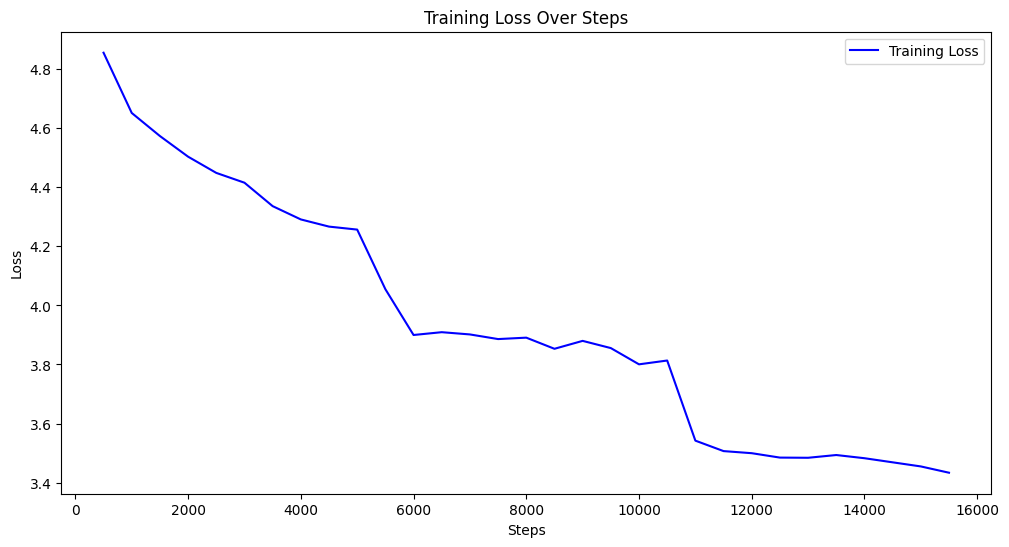

In [19]:
import matplotlib.pyplot as plt

def plot_training_loss(log_history):
    # Extract loss values and steps from log history
    steps = [log['step'] for log in log_history if 'loss' in log]
    losses = [log['loss'] for log in log_history if 'loss' in log]
    
    plt.figure(figsize=(12, 6))
    plt.plot(steps, losses, label='Training Loss', color='blue')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Steps')
    plt.legend()
    plt.show()

# After training, extract and plot training loss
log_history = trainer.state.log_history
plot_training_loss(log_history)

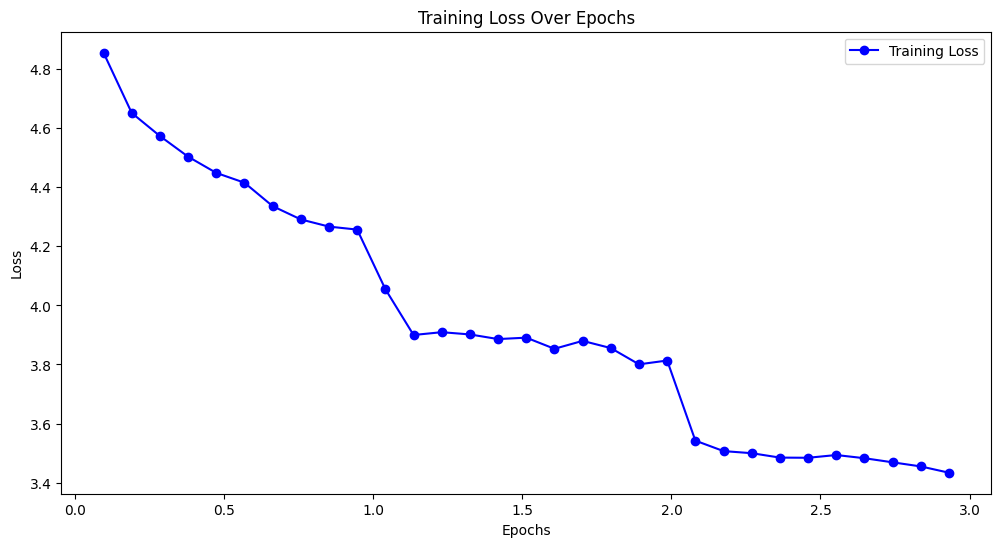

In [20]:
import matplotlib.pyplot as plt

def plot_training_loss(log_history):
    # Extract loss values and epochs from log history
    epochs = [log['epoch'] for log in log_history if 'loss' in log and 'epoch' in log]
    losses = [log['loss'] for log in log_history if 'loss' in log and 'epoch' in log]
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, losses, marker='o', label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

# After training, extract and plot training loss
log_history = trainer.state.log_history
plot_training_loss(log_history)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


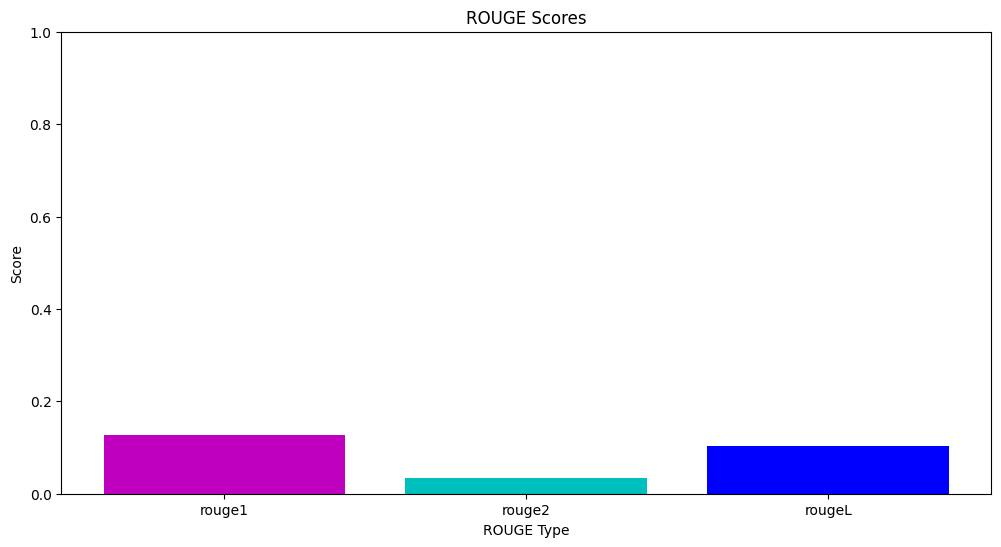

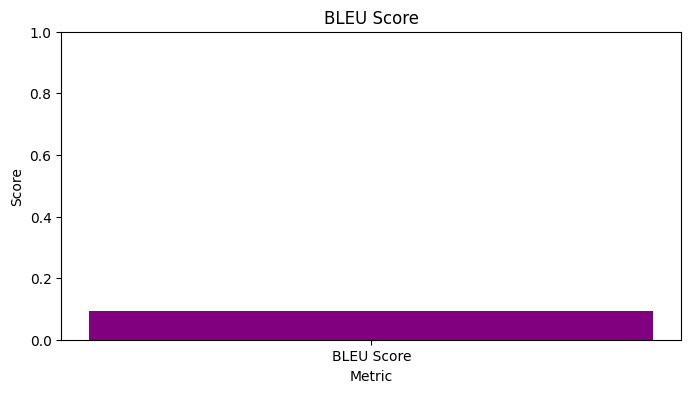

In [21]:
# Evaluate the model to get the metrics
eval_results = trainer.evaluate()

# Extract ROUGE and BLEU scores from evaluation results
rouge_scores = {
    'rouge1': eval_results['eval_rouge1'],
    'rouge2': eval_results['eval_rouge2'],
    'rougeL': eval_results['eval_rougeL']
}
bleu_score = eval_results['eval_bleu']

import matplotlib.pyplot as plt

# Function to plot ROUGE scores
def plot_rouge_scores(rouge_scores):
    plt.figure(figsize=(12, 6))
    plt.bar(rouge_scores.keys(), rouge_scores.values(), color=['m', 'c', 'b'])
    plt.title('ROUGE Scores')
    plt.xlabel('ROUGE Type')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()

# Function to plot BLEU score
def plot_bleu_score(bleu_score):
    plt.figure(figsize=(8, 4))
    plt.bar(['BLEU Score'], [bleu_score], color='purple')
    plt.title('BLEU Score')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()

# Plot the metrics
plot_rouge_scores(rouge_scores)
plot_bleu_score(bleu_score)

In [22]:
print(eval_results)

{'eval_loss': 3.7626874446868896, 'eval_rouge1': 0.1281531173432092, 'eval_rouge2': 0.0336188779968519, 'eval_rougeL': 0.10247987594518913, 'eval_bleu': 0.09412695086195616, 'eval_f1': 0.0027213790889346013, 'eval_runtime': 1210.718, 'eval_samples_per_second': 11.647, 'eval_steps_per_second': 2.912, 'epoch': 3.0}


In [24]:
model_device = next(model.parameters()).device

inputs = {key: value.to(model_device) for key, value in inputs.items()}


import torch
# Ensure the model is in evaluation mode
model.eval()

# **Check the model's device**
model_device = next(model.parameters()).device

# **Move the inputs to the same device as the model**
inputs = {key: value.to(model_device) for key, value in inputs.items()}

# Generate the answer
with torch.no_grad():
    outputs = model.generate(inputs["input_ids"], max_length=100, num_beams=2, early_stopping=True)

# Decode the generated answer
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(answer)


it depends on your specific needs and preferences if you are looking for an online platform that offers a wide range of services and products you can consider it's important to research and compare different platforms to find the one that best fits your needs and budget
